In [1]:
import os
import torch
import timm
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageEnhance
from matplotlib import cm

C:\Users\onkar\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Load fine-tuned model
model = timm.create_model("vit_tiny_patch16_224", pretrained=False, num_classes=10)
model.load_state_dict(torch.load("saved_models/vit_cifar10.pth", map_location=device))
model.to(device)
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()


In [4]:
# CIFAR-10 classes and types
cifar10_classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

object_types = {
    "airplane": "Vehicle", "automobile": "Vehicle", "ship": "Vehicle", "truck": "Vehicle",
    "bird": "Animal", "cat": "Animal", "deer": "Animal", "dog": "Animal",
    "frog": "Animal", "horse": "Animal"
}

In [5]:
# GradCAM hooks
activations = {}
gradients = {}

In [6]:
def save_activation(name):
    def hook(module, input, output):
        activations[name] = output
    return hook

In [7]:
def save_gradient(name):
    def hook(module, grad_input, grad_output):
        gradients[name] = grad_output[0]
    return hook

In [8]:
target_layer = model.blocks[-1].norm1
target_layer.register_forward_hook(save_activation("last_feat"))
target_layer.register_full_backward_hook(save_gradient("last_feat"))

In [9]:
# Preprocessing
preprocess = T.Compose([
    T.Resize((224, 224), interpolation=Image.BICUBIC),
    T.ToTensor(),
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [10]:
# GradCAM calculation
def compute_vit_gradcam(input_tensor, class_idx):
    input_tensor = input_tensor.to(device)
    output = model(input_tensor)
    score = output[0, class_idx]
    model.zero_grad()
    score.backward(retain_graph=True)

    grads = gradients["last_feat"]
    fmap = activations["last_feat"]
    weights = grads.mean(dim=1, keepdim=True)
    cam = torch.relu((weights * fmap).sum(dim=-1)).squeeze(0)

    cam = cam[1:]  # remove CLS token
    grid_size = int(cam.shape[0] ** 0.5)
    cam = cam.reshape(grid_size, grid_size).detach().cpu()
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    return cam.numpy()

In [11]:
# Overlay with high contrast and sharper focus
def apply_overlay(original_img, heatmap, alpha=0.5):
    # Min-max normalize heatmap
    heatmap = np.clip(heatmap, 0, 1)
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    heatmap = heatmap ** 1.0  # optional: mild gamma adjustment

    # Use 'jet' colormap for vibrant contrast
    colormap = cm.jet(heatmap)[:, :, :3]
    heatmap_img = Image.fromarray((colormap * 255).astype(np.uint8)).resize(original_img.size)

    # Slight enhancement to original
    base = original_img.convert("RGBA")
    base = ImageEnhance.Contrast(base).enhance(1.6)
    base = ImageEnhance.Sharpness(base).enhance(1.8)

    return Image.blend(base, heatmap_img.convert("RGBA"), alpha=alpha)

In [13]:
# Input image folder
image_folder = r"C:\Users\onkar\Downloads\Final_Project_Group_09\images"
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith((".jpg", ".png"))]

if not image_files:
    raise Exception("No image files found!")


Processing image 1: cat42.jpg

Top 5 classes:
3  : cat        | type = Animal   | prob = 99.90%
7  : horse      | type = Animal   | prob = 0.03%
2  : bird       | type = Animal   | prob = 0.02%
5  : dog        | type = Animal   | prob = 0.02%
4  : deer       | type = Animal   | prob = 0.01%


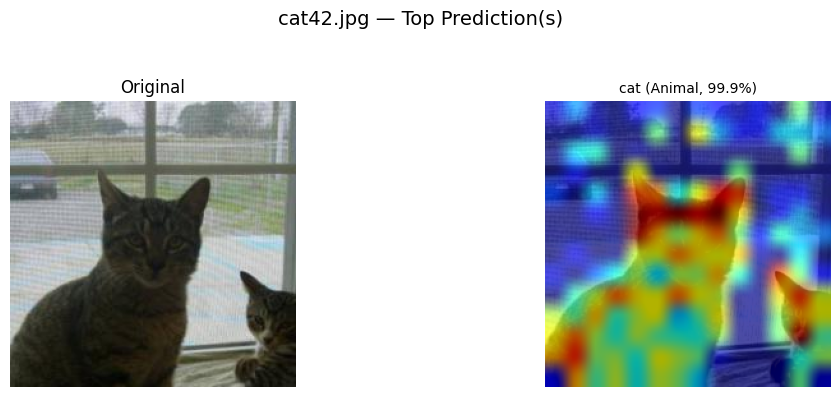


Processing image 2: cat70.jpg

Top 5 classes:
3  : cat        | type = Animal   | prob = 99.68%
5  : dog        | type = Animal   | prob = 0.30%
1  : automobile | type = Vehicle  | prob = 0.01%
7  : horse      | type = Animal   | prob = 0.01%
2  : bird       | type = Animal   | prob = 0.00%


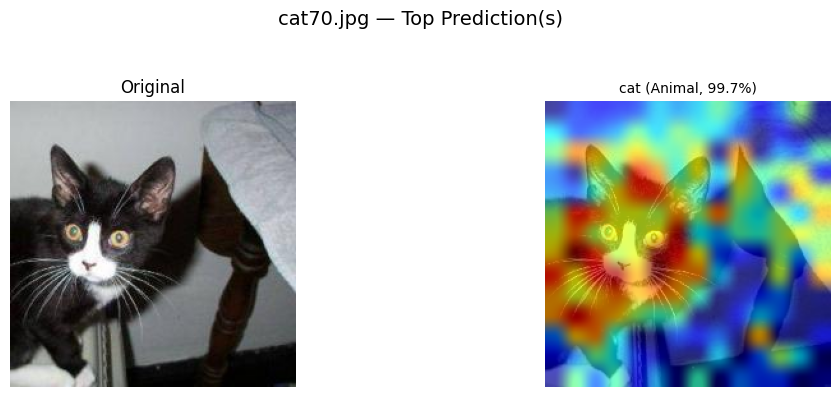


Processing image 3: catdog5.jpg

Top 5 classes:
3  : cat        | type = Animal   | prob = 90.82%
5  : dog        | type = Animal   | prob = 9.05%
7  : horse      | type = Animal   | prob = 0.04%
6  : frog       | type = Animal   | prob = 0.04%
8  : ship       | type = Vehicle  | prob = 0.02%


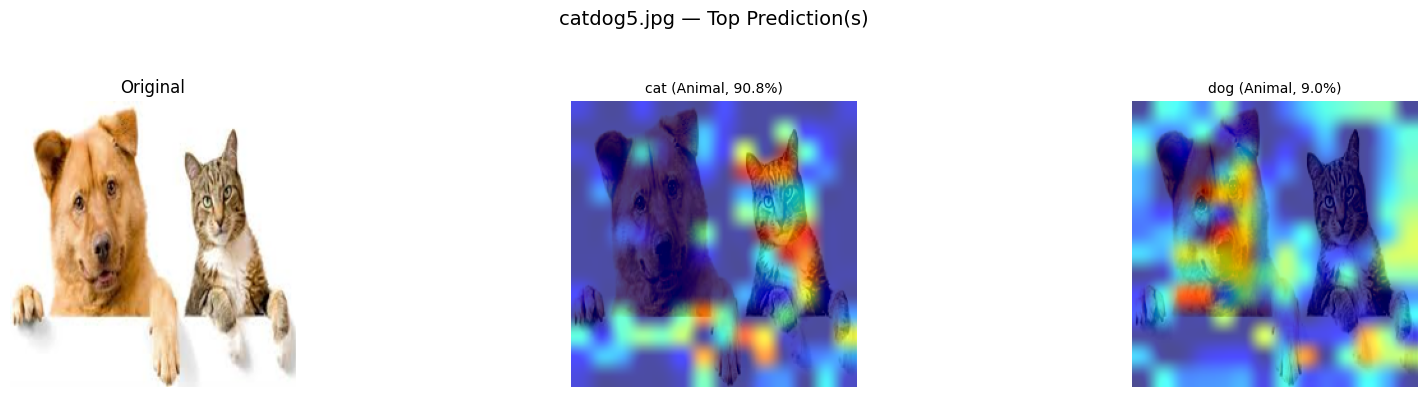

In [14]:
# Run per image
for idx, image_file in enumerate(image_files):
    print(f"\nProcessing image {idx + 1}: {image_file}")
    image_path = os.path.join(image_folder, image_file)

    try:
        original_img = Image.open(image_path).convert("RGB")
        resized = original_img.resize((224, 224))
        input_tensor = preprocess(resized).unsqueeze(0).to(device)

        activations.clear()
        gradients.clear()

        # Forward pass
        with torch.no_grad():
            logits = model(input_tensor)
            probs = torch.softmax(logits, dim=1)[0]

        # Top 5 class display
        top5 = torch.topk(probs, k=5)
        indices = top5.indices
        values = top5.values

        print("\nTop 5 classes:")
        for i in range(5):
            class_idx = indices[i].item()
            class_name = cifar10_classes[class_idx]
            obj_type = object_types.get(class_name, "Unknown")
            prob = values[i].item() * 100
            print(f"{class_idx:<2} : {class_name:<10} | type = {obj_type:<8} | prob = {prob:.2f}%")

        # Display settings
        show_second = values[1].item() > 0.03
        ncols = 2 if show_second else 1
        fig, axes = plt.subplots(nrows=1, ncols=ncols + 1, figsize=(6 * (ncols + 1), 4))
        fig.suptitle(f"{image_file} — Top Prediction(s)", fontsize=14)

        # Original image
        axes[0].imshow(resized)
        axes[0].set_title("Original")
        axes[0].axis("off")

        # Top-1 overlay
        class_idx = indices[0].item()
        class_name = cifar10_classes[class_idx]
        obj_type = object_types.get(class_name, "Unknown")
        prob = values[0].item() * 100

        cam = compute_vit_gradcam(input_tensor, class_idx)
        overlay = apply_overlay(resized, cam, alpha=0.7)

        axes[1].imshow(overlay)
        axes[1].axis("off")
        axes[1].set_title(f"{class_name} ({obj_type}, {prob:.1f}%)", fontsize=10)

        # Optional Top-2
        if show_second:
            class_idx2 = indices[1].item()
            class_name2 = cifar10_classes[class_idx2]
            obj_type2 = object_types.get(class_name2, "Unknown")
            prob2 = values[1].item() * 100

            cam2 = compute_vit_gradcam(input_tensor, class_idx2)
            overlay2 = apply_overlay(resized, cam2, alpha=0.7)

            axes[2].imshow(overlay2)
            axes[2].axis("off")
            axes[2].set_title(f"{class_name2} ({obj_type2}, {prob2:.1f}%)", fontsize=10)

        plt.tight_layout(rect=[0, 0, 1, 0.93])
        plt.show()
        
    except Exception as e:
        print(f"Failed on {image_file}: {e}")